# **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note** If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

Helper functions are listed as follows:

In [1]:
#importing some useful packages
import math
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
from sklearn.linear_model import LinearRegression
%matplotlib inline

# in order to get stable lane, buffer N frames' slopes and intercepts
pre_l_slopes = []
pre_l_inters = []  
pre_r_slopes = []
pre_r_inters = []


def clear_buffer():
    """
    rest the lines buffer
    :return:
    """
    pre_l_slopes.clear()
    pre_l_inters.clear()
    pre_r_slopes.clear()
    pre_r_inters.clear()

def selectWhiteAndYellow(img):
    """
    selec the white and yellow component in the hsv space.
    (1) set the yellow/white lower and upper bound
    (2) apply the mask to the hsv space image
    """
    lower_yellow = np.array([65, 100, 100], np.uint8)
    upper_yellow = np.array([105, 255, 255], np.uint8)
    yellow_mask = cv2.inRange(img, lower_yellow, upper_yellow)

    lower_white = np.array([0, 0, 200])
    upper_white = np.array([179, 20, 255])  # range for H is 0:179
    white_mask = cv2.inRange(img, lower_white, upper_white)

    img = cv2.bitwise_and(img, img, mask=cv2.bitwise_or(yellow_mask, white_mask))
    return img

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)


def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)


def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)


def region_of_interest(img, vertices):
    """
    Applies an image mask.

    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    # defining a blank mask to start with
    mask = np.zeros_like(img)

    # defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255

    # filling pixels inside the polygon defined by "vertices" with the fill color
    cv2.fillPoly(mask, vertices, ignore_mask_color)

    # returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def outlierCleaner(predictions, x, y, inlier_percent=0.9):
    """
        Clean away the 10% of points that have the largest
        residual errors (difference between the prediction
        and the actual y values).

        Return a list of tuples named cleaned_data where
        each tuple is of the form (x, y, error).
    """
    threshold = 10  # if the biggest error is greater than 5 pixels, we perform outliers remove
    errs = np.fabs(y - predictions)
    max_err = max(errs)[0]
    if max_err > threshold:  # if the biggest error is greater than 5 pixels, we remove the outliers
        k = math.ceil(errs.size * inlier_percent)
        survived_idx = np.argsort(errs, axis=0)[:k]  # find the number of k min errs, and return their index
        if survived_idx.size > 0:
            x = np.take(x, survived_idx)
            y = np.take(y, survived_idx)

    return (x, y)

def findTwoPoints(slope, inter, side, height):
    """
    In order to get two stable lanes,
    (1) average the slope and itercept values in the buffers, 
    (2) fix the y coordinate of the top points
    (3) then use the averaged slope and inter to locate the two end points of a line

    :param slope: current slope from the regressor for current frame
    :param inter: current intercept from the regressor for current frame
    :param side:  'l': left, 'r': right lane
    :param height: hight of the image
    :return tow points locations, which are the two ends of a lane
    """
    number_buffer_frames = 3
    scale_y = 0.65
    top_y = int(float(height) * scale_y)  # fix the y coordinates of the top point, so that the line is more stable
    

    if side == 'l':
        if len(pre_l_slopes) == number_buffer_frames:  # reach the max
            pre_l_slopes.pop(0)  # remove the oldest frame
            pre_l_inters.pop(0)

        pre_l_slopes.append(slope)
        pre_l_inters.append(inter)
        slope = sum(pre_l_slopes) / len(pre_l_slopes)
        inter = sum(pre_l_inters) / len(pre_l_inters)

        p1_y = height-1
        p1_x = int((float(p1_y)-inter)/slope)
        p2_y = top_y
        p2_x = int((float(p2_y)-inter)/slope)
    else:  # 'r'
        if len(pre_r_slopes) == number_buffer_frames:  # reach the max
            pre_r_slopes.pop(0)  # remove the oldest frame
            pre_r_inters.pop(0)

        pre_r_slopes.append(slope)
        pre_r_inters.append(inter)
        slope = sum(pre_r_slopes) / len(pre_r_slopes)
        inter = sum(pre_r_inters) / len(pre_r_inters)

        p1_y = top_y
        p1_x = int((float(p1_y)-inter)/slope)
        p2_y = height-1
        p2_x = int((float(p2_y)-inter)/slope)

    return (p1_x, p1_y, p2_x, p2_y)


def regress_a_lane(img, x, y, color=[255, 0, 0], thickness=10):
    """ regress a line from x, y and add it to img
    (1) use a linear regressor to fit the data (x,y)
    (2) remove outlier, and then fit the cleaned data again to get slope and intercept
    (3) find the two ends of the desired line by using slope and intercept
    
    :param img: input image
    :param x: x coordinate
    :param y: y coordinate
    :param color: line color
    :param thickness: thickness of the line  
    """
    reg = LinearRegression()
    reg.fit(x, y)

    # identify and remove outliers
    cleaned_data = []
    try:
        predictions = reg.predict(x)
        cleaned_data = outlierCleaner(predictions, x, y)
    except NameError:
        print("err in regression prediction")

    if len(cleaned_data) > 0:
        x, y = cleaned_data   
        # refit cleaned data!
        try:
            reg.fit(x, y)
        except NameError:
            print("err in reg.fit for cleaned data")
    else:
        print("outlierCleaner() is returning an empty list, no refitting to be done")

    height = img.shape[0]
    slope = reg.coef_
    inter = reg.intercept_

    # find the two end points of the line by using slope and iter, and then visulize the line
    if reg.coef_ < 0:  # left lane
        p1_x, p1_y, p2_x, p2_y = findTwoPoints(slope, inter, 'l', height)
        cv2.line(img, (p1_x, p1_y), (p2_x, p2_y), color, thickness)
    else:  # right lane
        p1_x, p1_y, p2_x, p2_y = findTwoPoints(slope, inter, 'r', height)
        cv2.line(img, (p1_x, p1_y), (p2_x, p2_y), color, thickness)


def draw_lines(img, lines, color=[255, 0, 0], thickness=10):
    """
    (1) remove some horizontal lines with given threshold_angle
    (2) seperate the points belongs to the left and right lane by computing line slope
    (3) handle the left/right lane points to a linear regressor to fit the line, with additional 
        steps to remove the outliers for getting a better fit.
    """
    threshold_angle = 25  # if the line angle is between -25 to 25 degrees, lines are discarded
    threshold_slope = math.tan(threshold_angle / 180 * math.pi)
    left_lane_x = []
    left_lane_y = []
    right_lane_x = []
    right_lane_y = []

    for line in lines:
        for x1, y1, x2, y2 in line:
            if x2 != x1:
                slope = float(y2 - y1) / float(x2 - x1)
                if abs(slope) < threshold_slope:  # remove the horizontal lines
                    continue
                elif slope < 0:  # left lane, note the origin is on the left-up corner of the image
                    left_lane_x.append([x1])
                    left_lane_y.append([y1])
                    left_lane_x.append([x2])
                    left_lane_y.append([y2])
                else:
                    right_lane_x.append([x1])
                    right_lane_y.append([y1])
                    right_lane_x.append([x2])
                    right_lane_y.append([y2])

    # get left and right solid lanes with regression
    if len(left_lane_x) > 0:  # if there are no enough points at the current frame
        regress_a_lane(img, left_lane_x, left_lane_y)
    if len(right_lane_x) > 0:
        regress_a_lane(img, right_lane_x, right_lane_y)


def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.

    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len,
                            maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img


# Python 3 has support for cool math symbols.
def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.

    `initial_img` should be the image before any processing.

    The result image is computed as follows:

    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

## Image Processing Pipeline for lane detection and visualization
see details in function drawLanesPipeline

In [2]:
def drawLanesPipeline(image):
    """ Process one image, detect two lanes and highlight them with solid color lines
    (1) apply the gaussian blur
    (2) convert bgr to hsv and segment while and yellow, because it is easier in HSV space than RGB
    (3) Canny edge detection
    (4) apply the designed mask to the image to obtian the region of interest
    (5) apply hough transform to get lines
    (6) augmented the lanes on the original image
    
    :param image: input image
    :return: an augmented image with two lane highlighted
    """

    #---------set parameters----------#
    # gaussian_blur para
    kernel_size = 5
    # canny edege detection para
    low_threshold = 50
    high_threshold = 150
    # region_of_interest para
    height, width, _ = image.shape
    scale_w = 7 / 16
    scale_h = 11 / 18
    left_bottom = [0, height - 1]
    right_bottom = [width - 1, height - 1]
    left_up = [scale_w * width, scale_h * height]
    right_up = [(1 - scale_w) * width, scale_h * height]
    # hough_line para
    rho = 2  # distance resolution in pixels of the Hough grid
    theta = np.pi / 180  # angular resolution in radians of the Hough grid
    threshold = 15  # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 15  # minimum number of pixels making up a line
    max_line_gap = 40  # maximum gap in pixels between connectable line segments
    #---------------------------------#

    # Define a kernel size and apply Gaussian smoothing
    blur_gray = gaussian_blur(image, kernel_size)

    # convert image from bgr to hsv
    hsv_img = cv2.cvtColor(blur_gray, cv2.COLOR_BGR2HSV)
    
    # filter out the white and yellow segments (lanes are either white or yellow in this case)
    filtered_hsv = selectWhiteAndYellow(hsv_img)

    # Apply Canny edge detection
    edges = canny(filtered_hsv, low_threshold, high_threshold)

    # create a masked edges image
    vertices = np.array([[left_bottom, left_up, right_up, right_bottom]], dtype=np.int32)
    masked_edges = region_of_interest(edges, vertices)

    # Run Hough on edge detected image
    # Output "lines" is an array containing endpoints of detected line segments
    line_image = hough_lines(masked_edges, rho, theta, threshold, min_line_length, max_line_gap)

    # Draw the lines on the edge image
    output = weighted_img(line_image, image)

    return output

## Test on Images

Now you should build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

run your solution on all test_images and make copies into the test_images directory).

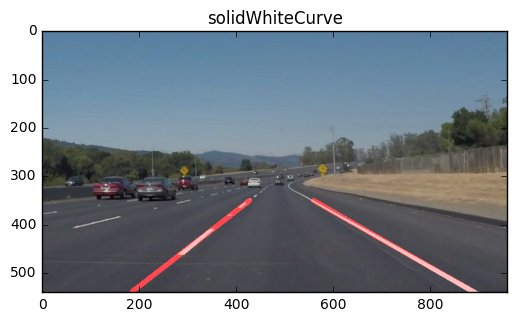

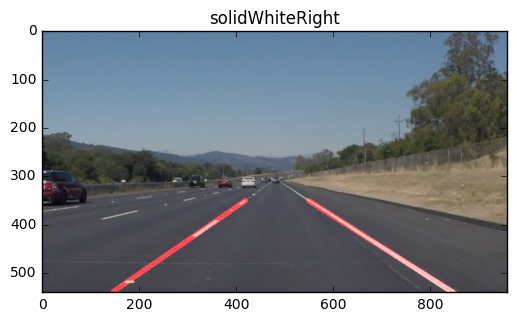

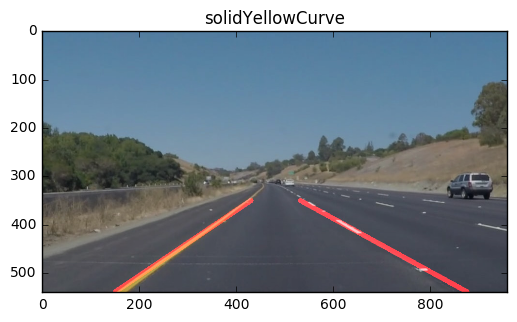

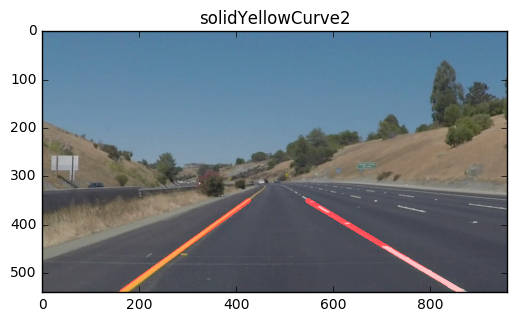

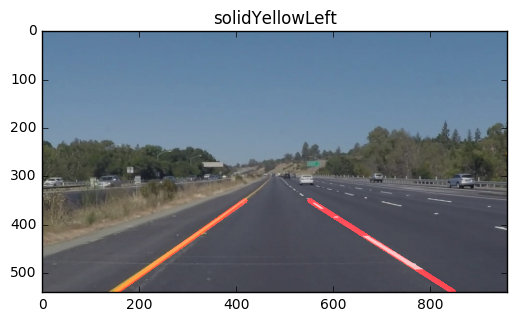

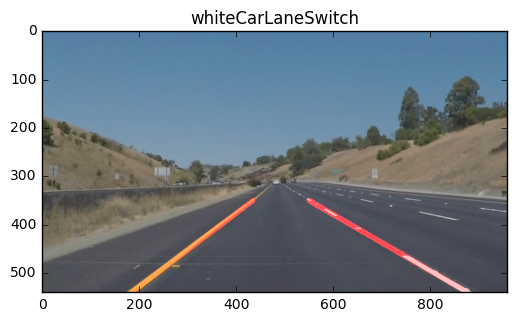

In [3]:
for fn in os.listdir("test_images/"):
    fileName, ending = os.path.splitext(fn)
    if ending != ".jpg":
        continue

    image = mpimg.imread(os.path.join("test_images", fileName + ending))
    
    clear_buffer()
    # draw two lanes on the image
    image_augmented = drawLanesPipeline(image)

    # write images to folder
    new_filename = os.path.join("test_images", "augmented",fileName + "_augmented.jpg")
    mpimg.imsave(new_filename, image_augmented)

    plt.imshow(image_augmented)
    plt.title(fileName)
    plt.show(block=True)

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

In [4]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [5]:
def process_image(image):
    # call the pipeline for each video frame
    result = drawLanesPipeline(image)
    return result

Let's try the one with the solid white lane on the right first ...

In [6]:
white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
clear_buffer()
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4


100%|█████████▉| 221/222 [00:06<00:00, 31.90it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

CPU times: user 6.66 s, sys: 968 ms, total: 7.63 s
Wall time: 7.76 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [7]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

**At this point, if you were successful you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform.  Modify your draw_lines function accordingly and try re-running your pipeline.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [8]:
yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
clear_buffer()
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video yellow.mp4
[MoviePy] Writing video yellow.mp4


100%|█████████▉| 681/682 [00:22<00:00, 30.62it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: yellow.mp4 

CPU times: user 20.9 s, sys: 3.23 s, total: 24.1 s
Wall time: 22.9 s


In [9]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Reflections

(1) How to handle the shadow area in "challenge.mp4"
In my first implemented, it was in RGB space instead of the HSV space, and that version works quite OK until meet the “challenge.mp4”. It starts to fail when the car drives into the shadow of the trees, in which case edge detector tends to grab the boundaries of the shadow instead of the yellow lane under the shadow. After I switch to HSV space, the lane extraction is much more robust.

(2) How to get a stable lane
Firstly, I buffer the left and right lanes' slope and intercepts of N frames (in this case is 3), then when I average the current frame's slope and intercept with the previous one.
Secondly, when I draw a lane with computed slope and intercept, I fixe the top point's vertical position. 
Thirdly, I try to remove the outliers by discarding some horizontal lines.
Fourthly, within the linear regression, I remove 10% of points that have the largest residual errors. Due to there are not many outliers, I only iterate the outlier removal once.

(3) How to make it better
Firstly, since I fix two lanes' top point's vertical location, so when it comes to sharp curved road, the lane will overshoot. I consider to use better fit than linear line to get better visual appealing.
Secondly,  if we want to make it more visual appealing, we can segment all visible lanes in the road, and highlights the with different colors, e.g. the both the driving lane with green, and the other lane for the coming cars with red. 

## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [10]:
challenge_output = 'extra.mp4'
clip2 = VideoFileClip('challenge.mp4')
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video extra.mp4
[MoviePy] Writing video extra.mp4


100%|██████████| 251/251 [00:15<00:00, 15.94it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: extra.mp4 

CPU times: user 14.8 s, sys: 2.33 s, total: 17.1 s
Wall time: 17.1 s


In [11]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))